## Extracting Crops

Previous notebooks created 360x360 images where nodes where placed in `2.2.1-constraint_data_gen.ipynb` and these nodes were then connected with constraints in `2.2.2-connecting_nodes.ipynb`.

In this notebook pairs of nodes are selected from these images.
Crops are generated using the nodes as coordinates `x1`, `y1`, `x2`, `y2`, which can be classfied after type of the constraint (no constraint, rotational or translational).

First the `config.json` of the previous notebook is loaded and the data presented.

In [1]:
import os
from os import path

import cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

from src.utils import encode_image_data_as_record

In [2]:
raw = path.join('data', 'sep_interim_02')
interim = path.join('data', 'sep_interim_03')
processed = path.join('data', 'sep_processed_01')
os.makedirs(interim, exist_ok=True)
os.makedirs(processed, exist_ok=True)

interim_prev = path.join('data', 'sep_interim_02')

df_prev = pd.read_json(path.join(interim_prev, 'config.json'))
df_prev.head()

,image_path,nodes,constraints
0,data\sep_interim_02\0.png,"[{'node_path': 'data/sep_raw_01/o/757.png', 'l...",[{'constraint_path': 'data\sep_raw_02\r\350-44...
1,data\sep_interim_02\1.png,"[{'node_path': 'data/sep_raw_01/x/1094.png', '...",[{'constraint_path': 'data\sep_raw_02\r\350-44...
2,data\sep_interim_02\2.png,"[{'node_path': 'data/sep_raw_01/o/1199.png', '...",[{'constraint_path': 'data\sep_raw_02\r\350-44...
3,data\sep_interim_02\3.png,"[{'node_path': 'data/sep_raw_01/x/1164.png', '...",[{'constraint_path': 'data\sep_raw_02\r\350-44...
4,data\sep_interim_02\4.png,"[{'node_path': 'data/sep_raw_01/o/501.png', 'l...",[{'constraint_path': 'data\sep_raw_02\t\350-44...


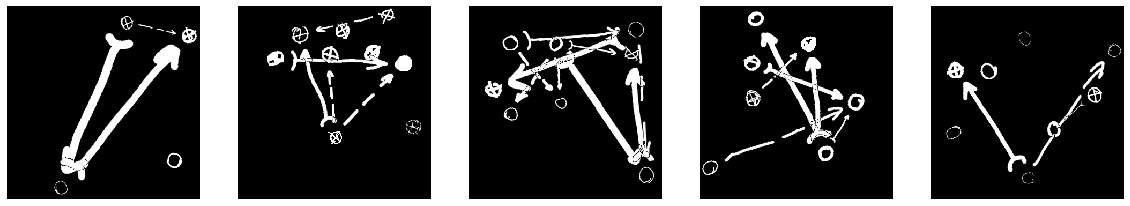

In [3]:
plt.figure(figsize=(20,20))

for idx, series in df_prev.head().iterrows():
    image = cv2.imread(series.image_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 5, idx + 1)
    plt.set_cmap('gray')
    plt.axis('off')
    plt.imshow(image)

plt.show()

In [4]:
pd.DataFrame(df_prev.nodes[0])

,node_path,label,x,y,b,h
0,data/sep_raw_01/o/757.png,o,311,289,32,32
1,data/sep_raw_01/x/617.png,x,220,32,32,32
2,data/sep_raw_01/o/247.png,o,101,339,32,32
3,data/sep_raw_01/x/880.png,x,340,56,32,32


In [5]:
pd.DataFrame(df_prev.constraints[0])

,constraint_path,label,idx_n1,idx_n2,x,y,w,l
0,data\sep_raw_02\r\350-449\391.png,r,1,2,160,185,111,279
1,data\sep_raw_02\t\350-449\139.png,t,1,3,280,44,11,72
2,data\sep_raw_02\r\350-449\20.png,r,2,3,220,197,310,320


### Creating crops


In [6]:
def get_label(constraints, idx, jdx):
    labels = ['n', 'r', 't']
    for c in image_data['constraints']:
        if c['idx_n1'] == idx and c['idx_n2'] == jdx:
            return labels.index(c['label'])
    return labels.index('n')

data_list = []

# compensate for the mean of nodes to get ~100.000 images
mean = df_prev.nodes.str.len().mean()
compensation =  (mean**2 - mean)

for image_idx, image_data in tqdm(df_prev.iterrows(), total=len(df_prev)):
    image = cv2.imread(image_data['image_path'], cv2.IMREAD_GRAYSCALE)

    for idx, node1 in enumerate(image_data['nodes']):
        if np.random.random() > 1 / compensation:
            continue

        for jdx, node2 in enumerate(image_data['nodes']):
            x1 = min(node1['x'], node2['x'])
            y1 = min(node1['y'], node2['y'])
            x2 = max(node1['x'], node2['x'])
            y2 = max(node1['y'], node2['y'])
            # If width or height are 0 => continue
            if x1 == x2 or y1 == y2:
                continue
            
            crop = image[y1:y2, x1:x2]
            crop = cv2.resize(crop, (96, 96))
            # Let constraints always point from top-left => bot-right
            if x1 == node2['x']:
                crop = cv2.flip(crop, 1)
            if y1 == node2['y']:
                crop = cv2.flip(crop, 0)
            
            _, ext = os.path.splitext(image_data['image_path'])
            name = str(image_idx) + '_' + str(idx) + '_' + str(jdx) + ext
            image_path = path.join(interim, name)

            data_list.append({
                'image_path': image_path,
                'label': [get_label(image_data.constraints, idx, jdx)]
            })

            cv2.imwrite(image_path, crop)

df = pd.DataFrame(data_list)
df.to_json(path.join(interim, 'config.json'))

100%|██████████| 100000/100000 [08:43<00:00, 191.12it/s]


In [7]:
print('Number of generated images: %d' % len(df))

Number of generated images: 119189


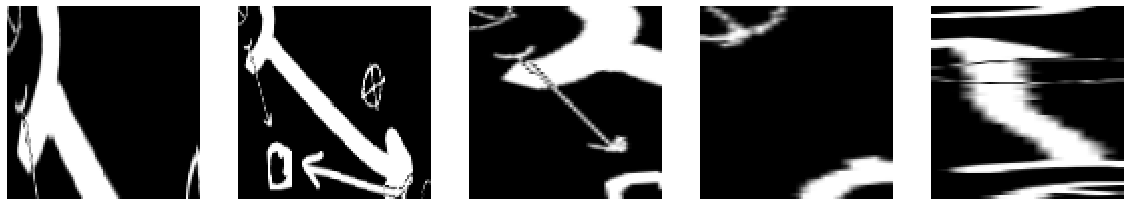

,image_path,label
0,data\sep_interim_03\7_0_1.png,[0]
1,data\sep_interim_03\7_0_2.png,[1]
2,data\sep_interim_03\7_0_3.png,[1]
3,data\sep_interim_03\7_0_4.png,[0]
4,data\sep_interim_03\10_5_0.png,[0]


In [8]:
plt.figure(figsize=(20,20))

for idx, series in df.head().iterrows():
    image = cv2.imread(series.image_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 5, idx + 1)
    plt.set_cmap('gray')
    plt.axis('off')
    plt.imshow(image)

plt.show()

df.head()

These images can then be used to be fed into a model.

Images are encoded into a `tensorflow-record` to be able to fed into the model in a faster fashion.

In [9]:
encode_image_data_as_record(df, path.join(processed, 'crops.tfrecord'))

100%|██████████| 119189/119189 [08:36<00:00, 230.63it/s]
